In [2]:
pip install --no-index --find-links=/kaggle/input/yde-arc25-wheelhouse yde-arc25

Looking in links: /kaggle/input/yde-arc25-wheelhouse
Processing /kaggle/input/yde-arc25-wheelhouse/yde_arc25-25.8.1-py3-none-any.whl
Processing /kaggle/input/yde-arc25-wheelhouse/nicegui-2.23.3-py3-none-any.whl (from yde-arc25)
Processing /kaggle/input/yde-arc25-wheelhouse/watchfiles-1.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from yde-arc25)
Processing /kaggle/input/yde-arc25-wheelhouse/scipy-1.16.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (from yde-arc25)
Processing /kaggle/input/yde-arc25-wheelhouse/cbor2-5.7.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (from yde-arc25)
Processing /kaggle/input/yde-arc25-wheelhouse/aiofiles-24.1.0-py3-none-any.whl (from nicegui->yde-arc25)
Processing /kaggle/input/yde-arc25-wheelhouse/ifaddr-0.2.0-py3-none-any.whl (from nicegui->yde-arc25)
Processing /kaggle/input/yde-arc25-wheelhouse/markdown2-2.5.4-py3-none-any.whl (from nicegui->yde-arc25)
Processing /kaggle/input/yde-a

In [3]:
pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 37.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.1 MB/s eta 0:00:00:00:0100:01
  Attempting un

In [4]:
if False:
    from huggingface_hub import notebook_login

    notebook_login()

In [5]:
import typing
import re
from pathlib import Path
from types import SimpleNamespace, MappingProxyType

import attrs
import numpy as np
import pandas as pd
from IPython import display

import arc25.dsl.types
from arc25 import dsl
import arc25.tools
import arc25.dataset

In [6]:
from pathlib import Path
ds = await arc25.dataset.Dataset.from_binary(Path("/kaggle/input/arc25-training-data/all-challenges.cbor.xz"))
solutions = await arc25.dataset.SolutionDB.load(Path("/kaggle/input/arc25-training-data/solutions"))
sol_with_code = sorted(k for k,v in solutions.solutions.items() if v.rule)
print(len(solutions.solutions), len(sol_with_code))
print(sol_with_code)

26 17
['00576224', '36fdfd69', '46442a0e', '54d82841', '5614dbcf', '642d658d', '6e19193c', '6f8cd79b', '9841fdad', '9f5f939b', 'a740d043', 'ca-00-01', 'ca-03-02', 'ca-03-04', 'ca-10-04', 'ce039d91', 'fd02da9e']


In [7]:
system_msg = "You are a careful, code-generating ARC challenge solver assistant."
task_descr = """
# Task description
ARC challenges require a rule to be found that transforms input grids into output grids.
You are given a number of pairs of input and output grids,
plus a few more input grids only, for which the rule must generate the corresponding outputs.
The rule must be expressed as a python function `solver`.
Analyse the challenge carefully and in a structured way by:
 1.) Formulate a `description` of the relevant semantic eneitites in the inputs.
 2.) Describe the underlying `rule` in natural language or pseudo-code.
 3.) Create a `plan` on how to implement the rule in python.
 4.) Output an `implemenetation` in python, implementing that rule.
"""

In [8]:
class FactDefinition:
    pass

@attrs.frozen
class PredicateFact(FactDefinition):
    descr: str
    predicate: typing.Callable

    def __call__(self, chal: arc25.dataset.Challenge) -> str | None:
        p = self.predicate(chal)
        if p:
            return self.descr.format(pred=p)

def single_element_or_none(arg: list|tuple|set):
    if len(arg) == 1:
        ret, = arg
        return ret
    
default_facts = (
    PredicateFact(
        "Inputs of equal shape: {pred}",
        lambda chal:single_element_or_none(set(e.input.shape for e in chal.train+chal.test))
    ),
    PredicateFact(
        "Output shapes match input shapes",
        lambda chal:all(e.output.shape == e.input.shape for e in chal.train)
    ),
    PredicateFact(
        "Output size uniformly increased by factor {pred}",
        lambda chal:single_element_or_none(set(
            d for d,m in (
                divmod(e.output.shape[i],e.input.shape[i])
                for i in range(2)
                for e in chal.train
            ) if not m and d>1
        ))
    ),
    PredicateFact(
        "Output size uniformly decreased by factor {pred}",
        lambda chal:single_element_or_none(set(
            d for d,m in (
                divmod(e.input.shape[i],e.output.shape[i])
                for i in range(2)
                for e in chal.train
            ) if not m and d>1
        ))
    ),
    # TODO: facts about colours
)

In [9]:
C = dsl.types.Color
single_char_color_codes = {
    C.BLACK: "k",
    C.BLUE: "b",
    C.BROWN: "n",
    C.CYAN: "c",
    C.GRAY: "h",
    C.GREEN: "g",
    C.MAGENTA: "m",
    C.ORANGE: "o",
    C.RED: "r",
    C.YELLOW: "y",
}
parentheses = "«»‹›〔〕【】〖〗❪❫❲❳❬❭❨❩⟨⟩"
len(set(single_char_color_codes.keys())),len(set(single_char_color_codes.values()))

(10, 10)

In [10]:
@attrs.frozen
class ReasonedSolution:
    input_descr: str | None = None
    rule_descr: str | None = None
    impl_plan_descr: str | None = None
    rule_impl: str | None = None

In [11]:
@attrs.frozen
class PromptEncoder:
    system_msg: str = system_msg
    task_descr: str = task_descr
    replace_all_colours: bool = True
    
    colour_tokens: tuple[str,...] = tuple(
        f"❲{single_char_color_codes[c]}❳"
        for c in dsl.types.Color
    )
    open_tokens: SimpleNamespace = SimpleNamespace(**{
        k:f"<{k}>" for k in ["input","example","grid","facts","descr","rule","plan","impl"]
    })
    close_tokens: SimpleNamespace = SimpleNamespace(**{
        k:f"</{k}>" for k in vars(open_tokens)
    })

    fact_definitions: tuple[FactDefinition] = default_facts

    
    def encode_grid(self, grid: dsl.types.Canvas) -> str:
        if isinstance(grid, dsl.types.Canvas):
            grid = grid.image
        h,w = grid.shape
        egrids = [
            "\n".join("".join(self.colour_tokens[v] for v in row) for row in d)
            for d in [grid._data,grid._data.T]
        ]
        o = self.open_tokens
        c = self.close_tokens
        return f"""
{o.grid}{h}×{w}
rows:
{egrids[0]}
---
cols:
{egrids[1]}
{c.grid}
        """.strip()

    def encode_example(self, example:  dsl.types.IOPair) -> str:
        o = self.open_tokens
        c = self.close_tokens
        body = "\n".join(
            f"{k}:{self.encode_grid(v)}"
            for k in ["input","output"]
            if (v:=getattr(example,k)) is not None
        )
        return f"""
{o.example}
{body}
{c.example}
        """.strip()

    def encode_inputs(self, challenge: arc25.dataset.Challenge) -> str:
        o = self.open_tokens
        c = self.close_tokens
        body = "\n".join(
            f"{k}:\n"+"\n".join(self.encode_example(e) for e in v)
            for k in ["train","test"]
            if (v:=getattr(challenge,k))
        )
        return f"""
{o.input}
{body}
{c.input}
        """.strip()

    def encode_facts(self, challenge: arc25.dataset.Challenge) -> str:
        o = self.open_tokens
        c = self.close_tokens
        # TODO: handle colour replacement!
        body = "\n".join(
            f"- {descr}"
            for fd in self.fact_definitions
            if (descr:=fd(challenge))
        )
        return f"""
{o.facts}
{body}
{c.facts}
        """.strip()

    def encode_prompt(self, challenge: arc25.dataset.Challenge) -> dict[str,str]:
        user_msg = f"""
{self.task_descr}

{self.encode_inputs(challenge)}

{self.encode_facts(challenge)}
""".strip()
        return SimpleNamespace(
            system = self.system_msg,
            user = user_msg,
        )

    def encode_response(self, response: ReasonedSolution) -> str:
        o = self.open_tokens
        c = self.close_tokens
        ret = []
        for k,v in dict(
            descr = response.input_descr,
            rule = response.rule_descr,
            plan = response.impl_plan_descr,
            impl = response.rule_impl,
        ).items():
            if v is None or not v.strip():
                continue
            ret.append(f"""
{vars(o)[k]}
{v}
{vars(c)[k]}
            """.strip())
        return "\n\n".join(ret)

ca-03-02


**Hypothesis:**
- Black background.
- One horizontal and one vertical colored dotted line.
- Impossible to say which of the two is painted over the other.

**Rule:**
- Start either from the input, or a fully black canvas of the same shape.
- First, paint a solid vertical line at the position and in the color of the dotted vertical line in the input.
- Second, paint a solid horizontal line at the position and in the color of the dotted horizontal line in the input.

**Plan:**
- There are no distractions, so we can determine the line positions simply from the count of foreground cells.


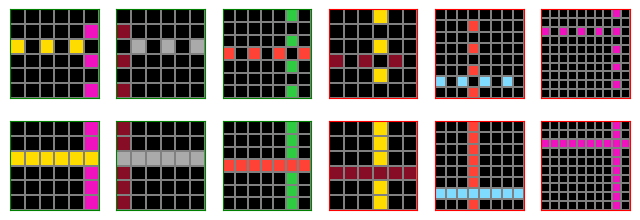

In [12]:
ckey = sol_with_code[-5]
print(ckey)
chal = ds.challenges[ckey]
sol = solutions.solutions[ckey]
display.display(display.Markdown(sol.explanation))

arc25.tools.show_test_case(
    chal.train+chal.test,
    n_train = len(chal.train),
    width = 8,
    orientation = "h",
)

In [13]:
header_rex = re.compile(r"\*\*(\w+):\*\*")
def parse_explanation(sol):
    resp = {}
    prev = None,0
    for m in header_rex.finditer(sol.explanation):
        t,s = prev
        e = m.start()
        resp.setdefault(t,[]).append(sol.explanation[s:e].strip())
        prev = {
            "hypothesis": "input_descr",
            "rule": "rule_descr",
            "plan": "impl_plan_descr",
        }.get(m.group(1).lower()), m.end()
    t,s = prev
    e = len(sol.explanation)
    resp.setdefault(t,[]).append(sol.explanation[s:e].strip())

    default = resp.pop(None,None)
    if default is not None and "rule_descr" not in resp:
        resp["rule_descr"] = default
    
    return ReasonedSolution(
        **{k:"".join(v) for k,v in resp.items()},
        rule_impl=sol.rule.strip(),
    )
resp = parse_explanation(sol)
resp

ReasonedSolution(input_descr='- Black background.\n- One horizontal and one vertical colored dotted line.\n- Impossible to say which of the two is painted over the other.', rule_descr='- Start either from the input, or a fully black canvas of the same shape.\n- First, paint a solid vertical line at the position and in the color of the dotted vertical line in the input.\n- Second, paint a solid horizontal line at the position and in the color of the dotted horizontal line in the input.', impl_plan_descr='- There are no distractions, so we can determine the line positions simply from the count of foreground cells.', rule_impl='def solution(input: Canvas) -> Canvas:\n    output = input\n    h,w = input.shape\n    # identify foreground cells\n    fg_mask = ~mask_color(input, BLACK)\n    # paint all columns with more than one foreground cell\n    # (there will be just one)\n    for col in range(w):\n        col_mask = mask_col(input, col)\n        mask = col_mask & fg_mask\n        if mask.

In [14]:
enc = PromptEncoder()

u = enc.encode_prompt(chal).user
print(u[:800]+"\n...\n"+u[-400:])
a = enc.encode_response(resp)
print(a)

# Task description
ARC challenges require a rule to be found that transforms input grids into output grids.
You are given a number of pairs of input and output grids,
plus a few more input grids only, for which the rule must generate the corresponding outputs.
The rule must be expressed as a python function `solver`.
Analyse the challenge carefully and in a structured way by:
 1.) Formulate a `description` of the relevant semantic eneitites in the inputs.
 2.) Describe the underlying `rule` in natural language or pseudo-code.
 3.) Create a `plan` on how to implement the rule in python.
 4.) Output an `implemenetation` in python, implementing that rule.


<input>
train:
<example>
input:<grid>6×6
rows:
❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳
❲k❳❲k❳❲k❳❲k❳❲k❳❲m❳
❲y❳❲k❳❲y❳❲k❳❲y❳❲k❳
❲k❳❲k❳❲k❳❲k❳❲k❳❲m❳
❲k❳❲k❳❲k❳❲k❳❲k
...
---
cols:
❲k❳❲k❳❲m❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳
❲k❳❲k❳❲m❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳
❲k❳❲k❳❲m❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳
❲k❳❲k❳❲m❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳
❲k❳❲k❳❲m❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳
❲k❳❲k❳❲m❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳❲k❳

In [15]:
MODEL_NAME = "Qwen/Qwen2.5-Coder-7B-Instruct"
MAX_LEN = 4096


In [16]:
from transformers import  AutoTokenizer

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
additional_special_tokens = tuple(
    list(enc.colour_tokens)
    +list(vars(enc.open_tokens).values())
    +list(vars(enc.close_tokens).values())
)
tok.add_special_tokens(dict(additional_special_tokens=additional_special_tokens))

def build_chat_text(chal: arc25.dataset.Challenge, resp: ReasonedSolution | None = None):
    messages = vars(enc.encode_prompt(chal))
    if sol is not None:
        messages.update(assistant=enc.encode_response(resp))
    messages = [
        dict(role=k,content=v)
        for k,v in messages.items()
    ]
    return tok.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=sol is None,  # False for SFT labels, True for inference
    )

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [17]:
text = build_chat_text(chal, resp)
print(text[:600] + "\n...\n" + text[-600:])

<|im_start|>system
You are a careful, code-generating ARC challenge solver assistant.<|im_end|>
<|im_start|>user
# Task description
ARC challenges require a rule to be found that transforms input grids into output grids.
You are given a number of pairs of input and output grids,
plus a few more input grids only, for which the rule must generate the corresponding outputs.
The rule must be expressed as a python function `solver`.
Analyse the challenge carefully and in a structured way by:
 1.) Formulate a `description` of the relevant semantic eneitites in the inputs.
 2.) Describe the underlyin
...
h more than one foreground cell
    # (there will be just one)
    for col in range(w):
        col_mask = mask_col(input, col)
        mask = col_mask & fg_mask
        if mask.count()>1:
            c, = most_common_colors(apply_mask(input, mask))
            output = fill(output, c, clip=col_mask)
    # same for the row
    for row in range(h):
        row_mask = mask_row(input, row)
     

In [18]:
token_to_tag = {}
for k,v in vars(enc.open_tokens).items():
    t = tok.convert_tokens_to_ids(v)
    token_to_tag[t] = "+"+k
for k,v in vars(enc.close_tokens).items():
    t = tok.convert_tokens_to_ids(v)
    token_to_tag[t] = "-"+k
    
IM_START  = tok.convert_tokens_to_ids("<|im_start|>")
IM_END    = tok.convert_tokens_to_ids("<|im_end|>")

def tokenize_with_sections(text):
    enc = tok(text, truncation=True, max_length=MAX_LEN, return_tensors="np")
    enc = {k:v[0,:] for k,v in enc.items()}
    input_ids = enc.pop("input_ids")

    # 1) Find the assistant turn boundaries: <|im_start|>assistant ... <|im_end|>
    #    We’ll only supervise inside; everything else -> labels = -100
    # Scan all <|im_start|> occurrences and pick the one where next token piece is "assistant"
    # Qwen template goes: <|im_start|>, "assistant", '\n', content..., <|im_end|>
    role_tokens = tok.encode("assistant\n", add_special_tokens=False)
    starts = np.flatnonzero(input_ids == IM_START)
    ends = np.flatnonzero(input_ids == IM_END)
    assistant_sections = []
    for i in starts:
        s = input_ids[i+1:][:len(role_tokens)]
        if np.all(s == role_tokens):
            j = np.searchsorted(ends,i)
            if j>=len(ends):
                j = len(input_ids)
            else:
                j = ends[j]
            assistant_sections.append((i,j))

    # 2) Inside assistant: assign tag weights + section content weights.
    # Walk tokens and push/pop when we encounter section tags.
    # Since tags are single tokens, we can index them directly.

    edges = [0]
    sections = [None]  
    for s,e in assistant_sections:
        open_stack = []  # holds section names currently open
        edges.append(s)
        sections.append(Ellipsis)

        ids = input_ids[s:e]
        pos = np.flatnonzero(np.any(ids[:,None] == np.array(list(token_to_tag.keys())),-1))
        for p in pos:
            edges.append(s+p)
            t = token_to_tag[ids[p]]
            if t.startswith("+"):
                t = t[1:]
                sections.append(t)
                open_stack.append(t)
            else:
                assert t.startswith("-")
                t = t[1:]
                assert open_stack[-1] == t
                open_stack.pop()
                sections.append(Ellipsis)

        edges.append(e)
        sections.append(None)

    edges.append(len(input_ids))
    return dict(tokens=input_ids, edges=np.array(edges), sections=tuple(sections), **enc)

tokenised = res = SimpleNamespace(**tokenize_with_sections(text))
print(f"{len(res.tokens)=} {vars(res).keys()}")
print(f"{len(res.edges)=}: {res.edges}")
print(f"{len(res.sections)=}: {res.sections}")
tsum = {}
for s,e,t in zip(res.edges[:-1],res.edges[1:],res.sections):
    if isinstance(t,str):
        tsum[t] = tsum.get(v,0) + e-s
for k,v in tsum.items():
    print(f"Section {k} has {v} tokens")

len(res.tokens)=2163 dict_keys(['tokens', 'edges', 'sections', 'attention_mask'])
len(res.edges)=12: [   0 1840 1843 1873 1875 1942 1944 1967 1969 2160 2161 2163]
len(res.sections)=11: (None, Ellipsis, 'descr', Ellipsis, 'rule', Ellipsis, 'plan', Ellipsis, 'impl', Ellipsis, None)
Section descr has 30 tokens
Section rule has 67 tokens
Section plan has 23 tokens
Section impl has 191 tokens


In [19]:
def create_labels_and_weights(inp, weight_map=MappingProxyType(dict(
    descr=0.5, rule=0.6, plan=0.8, impl=1.0
)), special_weight=0.2, pad_to:int|None=None):
    toks = inp["tokens"]
    edg = inp["edges"]
    sec = inp["sections"]
    labels = []
    weights = []
    for s,e,t in zip(edg[:-1],edg[1:],sec):
        n = e-s
        if t is None and not s:
            # this is the first user section; not supervising the token
            labels.append(np.tile(-100,n))
            weights.append(np.zeros(n))
            continue
        weights.append([special_weight])
        w = weight_map.get(t)
        if w is None:
            labels.append(toks[s:s+1])
            labels.append(np.tile(-100,n-1))
            weights.append(np.zeros(n-1))
        else:
            labels.append(toks[s:e])
            weights.append(np.tile(w,n-1))
    labels = np.concatenate(labels)
    weights = np.concatenate(weights)
    assert labels.shape == weights.shape == toks.shape
    ret = dict(input_ids=toks, labels=labels, weights=weights, attention_mask=inp["attention_mask"])
    if pad_to is not None and (n:=pad_to - toks.size) > 0:
        pad_token = tok.convert_tokens_to_ids(
            tok.eos_token if tok.pad_token is None else tok.pad_token
        )
        padding = dict(
            input_ids = pad_token,
            labels = -100,
            weights = 0.,
            attention_mask = 0,
        )
        ret = {
            k:np.concatenate([v,np.tile(np.array(padding[k],v.dtype),n)])
            for k,v in ret.items()
        }

    return ret
    
_ = create_labels_and_weights(vars(tokenised))

In [20]:
rgen = np.random.default_rng(42)
splits = dict(train=[],val=[])
for ckey,sol in sorted(solutions.solutions.items(),key=lambda kv:kv[0]):
    if not (sol.rule and sol.explanation):
        continue
    chal = ds.challenges[ckey]
    resp = parse_explanation(sol)
    text = build_chat_text(chal, resp)
    res = tokenize_with_sections(text)
    lw = create_labels_and_weights(res)
    split = "val" if rgen.random()<0.45 else "train"
    print(f"{ckey} has {len(lw['weights'])} tokens and goes into {split}")
    splits[split].append(lw)
splits = {k:pd.DataFrame(v) for k,v in splits.items()}
splits["train"].head()

00576224 has 733 tokens and goes into train
5614dbcf has 1116 tokens and goes into val
642d658d has 4096 tokens and goes into train
9f5f939b has 4096 tokens and goes into train
a740d043 has 872 tokens and goes into val
ca-00-01 has 4057 tokens and goes into train
ca-03-02 has 2163 tokens and goes into train
ca-03-04 has 2562 tokens and goes into train
ca-10-04 has 4096 tokens and goes into val
ce039d91 has 2685 tokens and goes into train


,input_ids,labels,weights,attention_mask
0,"[151644, 8948, 198, 2610, 525, 264, 16585, 11,...","[-100, -100, -100, -100, -100, -100, -100, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[151644, 8948, 198, 2610, 525, 264, 16585, 11,...","[-100, -100, -100, -100, -100, -100, -100, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[151644, 8948, 198, 2610, 525, 264, 16585, 11,...","[-100, -100, -100, -100, -100, -100, -100, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[151644, 8948, 198, 2610, 525, 264, 16585, 11,...","[-100, -100, -100, -100, -100, -100, -100, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[151644, 8948, 198, 2610, 525, 264, 16585, 11,...","[-100, -100, -100, -100, -100, -100, -100, -10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [21]:
import datasets as hf_datasets

for k,v in splits.items():
    ds_tok = hf_datasets.Dataset.from_pandas(v)
    ds_tok.save_to_disk(f"ds_tok/{k}")


Saving the dataset (0/1 shards):   0%|          | 0/7 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3 [00:00<?, ? examples/s]

In [22]:
from torch import nn
from transformers import TrainingArguments, Trainer

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, *, return_outputs=False, num_items_in_batch=None):
        # forward first
        outputs = model(**{k: v for k, v in inputs.items() if k not in ("labels","weights")})
        logits = outputs.logits                      # on the model’s last shard device
        dev = logits.device

        # fetch targets/weights and move to *logits* device (not labels.device!)
        labels  = inputs["labels"]
        weights = inputs["weights"]
        if not torch.is_tensor(weights):
            weights = torch.tensor(weights, dtype=torch.float32)
        labels  = labels.to(dev)
        weights = weights.to(dev, dtype=torch.float32)

        # causal shift
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()
        shift_wts    = weights[:, 1:].contiguous()

        loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
        loss_tok = loss_fct(shift_logits.view(-1, shift_logits.size(-1)),
                            shift_labels.view(-1)).view_as(shift_labels)

        active   = (shift_labels != -100).float()
        weighted = loss_tok * shift_wts * active
        denom    = (shift_wts * active).sum().clamp_min(1e-6)
        loss     = weighted.sum() / denom

        return (loss, outputs) if return_outputs else loss

2025-09-03 07:16:05.954936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756883766.176389     100 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756883766.238856     100 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [23]:
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

class FastSectionCollator:
    def __init__(self, tokenizer, pad_to_multiple_of=8):
        self.tok = tokenizer
        self.pad_to_multiple_of = pad_to_multiple_of
        self._pad_token_id = tok.convert_tokens_to_ids(self.tok.eos_token if self.tok.pad_token is None else self.tok.pad_token)

    def __call__(self, features):
        # features[i][k] are already torch tensors thanks to set_format(...)
        ids     = [f["input_ids"]     for f in features]
        attn    = [f["attention_mask"]for f in features]
        labels  = [f["labels"]        for f in features]
        weights = [f["weights"]       for f in features]

        input_ids      = pad_sequence(ids,     batch_first=True, padding_value=self._pad_token_id)
        attention_mask = pad_sequence(attn,    batch_first=True, padding_value=0)
        labels         = pad_sequence(labels,  batch_first=True, padding_value=-100)
        weights        = pad_sequence(weights, batch_first=True, padding_value=0.0)

        if self.pad_to_multiple_of:
            L, m = input_ids.size(1), self.pad_to_multiple_of
            if L % m:
                pad = (0, m - (L % m))
                input_ids      = F.pad(input_ids,      pad, value=self._pad_token_id)
                attention_mask = F.pad(attention_mask, pad, value=0)
                labels         = F.pad(labels,         pad, value=-100)
                weights        = F.pad(weights,        pad, value=0.0)

        return {
            "input_ids": input_ids,            # keep on CPU; Trainer/Accelerate moves them
            "attention_mask": attention_mask,
            "labels": labels,
            "weights": weights,
        }

In [25]:
import torch
from transformers import AutoModelForCausalLM, Trainer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model


bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,  # or torch.float16 if no bf16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_cfg,
    device_map="auto",
)

# make the embedding fit the extra tokens
model.resize_token_embeddings(
    len(tok),
    pad_to_multiple_of=8,
    mean_resizing=True,
)

lora = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    trainable_token_indices={'embed_tokens': tok.convert_tokens_to_ids(additional_special_tokens)},
)
model = get_peft_model(model, lora)

# memory savers
model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
model.config.use_cache = False
model.enable_input_require_grads()
model.config.attn_implementation = "sdpa"  # or "flash_attention_2" if installed


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
train_ds = hf_datasets.load_from_disk("ds_tok/train")
val_ds = hf_datasets.load_from_disk("ds_tok/val")

cols = ["input_ids", "attention_mask", "labels", "weights"]
train_ds.set_format(type="torch", columns=cols, output_all_columns=False)
val_ds.set_format(type="torch", columns=cols, output_all_columns=False)

In [ ]:
from transformers import TrainingArguments, DataCollatorForLanguageModeling

collator = FastSectionCollator(tok, pad_to_multiple_of=8)
# collator = DataCollatorForLanguageModeling(tok, mlm=False, pad_to_multiple_of=8)

args = TrainingArguments(
    output_dir="ckpt",
    bf16=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,
    learning_rate=2e-4,
    num_train_epochs=10,
    logging_steps=5,
    eval_strategy="steps",
    eval_steps=5,
    save_steps=500,
    save_total_limit=2,
    dataloader_num_workers=1,
    dataloader_persistent_workers=True,
    dataloader_pin_memory=True,
    report_to="none",
    remove_unused_columns=False,  # keep custom 'weights'
    label_names="labels",
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    processing_class=tok,
)

print(f"World size: {trainer.args.world_size}, local_rank: {trainer.args.local_rank}")
print("Using DDP:", trainer.args.world_size > 1)

trainer.train()

World size: 1, local_rank: 0
Using DDP: False


Step,Training Loss,Validation Loss
5,9.255600,No log


In [ ]:
from IPython.display import Javascript
print("Shutdown")
Javascript("Ipython.notebook.session.delete()")